# ARIMA Extra Practice

## What is ARIMA?

- ARIMA stands for Autoregressive Integrated Moving Average
- It is a statistical analysis model that uses time series data to either better understand the data set or to predict future trends. 
- `AR` refers to later values predicted by earlier / lagged values
- `I` refers to absolute values replaced by difference values e.g. % change in stock price
- `MA` refers to linear combinations of current and previous values

## Required Libraries
- This lesson requires the `pdarima` library which is a statistical library used for time series analysis
- `pdarima` can be installed with Python's `pip` command
- This command only needs to be done once per machine:

In [1]:
# pip install pmdarima

If the above command didn't work, it may be necessary to be more explicit, in which case you could run the code below.

In [2]:
### For Python
# import sys
# !{sys.executable} -m pip install pmdarima

Once `pdarima` is installed, then load the libraries below.

In [3]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from pmdarima.arima import auto_arima

## Load Data

In [4]:
df = pd.read_csv('data/AirPassengers.csv', parse_dates=['Month'], index_col=['Month'])

# Plot Data

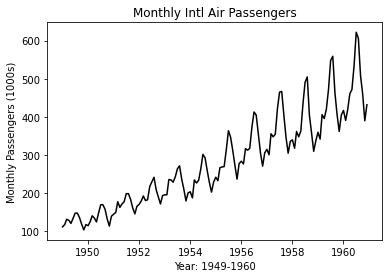

In [5]:
fig, ax = plt.subplots()
plt.xlabel('Year: 1949-1960')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly Intl Air Passengers')
plt.plot(df, color='black')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

## Split Data

- Our goal is to predict future values in the time series.
- To do this, we'll use data from 1949 through 1957 for training the model.
- We'll then use data from 1958 through 1960 for testing the predictions.

### Create Training Dataset

- Select data from before 1958.

In [6]:
trn = df.loc[df.index < '1958-01-01']

- Plot the training data.

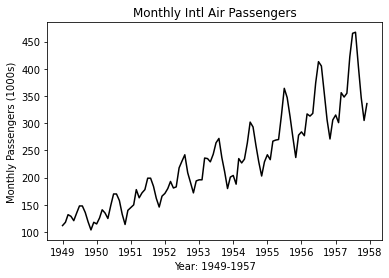

In [7]:
fig, ax = plt.subplots()
plt.xlabel('Year: 1949-1957')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly Intl Air Passengers')
plt.plot(trn, color='black')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

### Create Test Data Set

- Use data from 1958 through 1960 (the last three years) for testing.

In [8]:
tst = df.loc[df.index >= '1958-01-01']

- Plot the testing data.
- Note that the vertical scale changes from the previous graph.

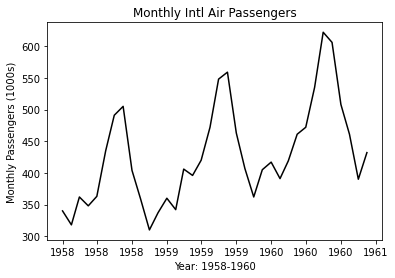

In [9]:
fig, ax = plt.subplots()
plt.xlabel('Year: 1958-1960')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly Intl Air Passengers')
plt.plot(tst, color='black')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

## Prepare Model

### Test Stationarity / Non-Stationarity

ARIMA models (depending on the library used) require either stationary data or non-stationary data. 

#### Example: Test for non-stationarity

If the data is required to be non-stationary, then, ARIMA needs data where the mean, the variance, and the covariance vary over time. Non-stationary data shows significant correlations when lagged. A "correlogram" graph (or ACF plot) shows the degree of correlation at different values of lag. 

The blue shaded area refers to 95% Confidence Interval of the Auto-Correlation Scores. This is also a way to check if the correlations are significant i.e. scores fall outside the Confidence Interval.

For the test of non-stationarity, all the lag values will fall outside the Confidence Interval which would then mean that the data is inherently seasonal in nature (assuming the mean, variance and covariance are non-constant over time).


#### Example: Test for Stationarity

If the data is required to be stationary, then, ARIMA needs data where the mean, the variance, and/or the covariance are constant over time. Stationary data shows insignificant correlations when lagged. A "correlogram" graph (or ACF plot) shows the degree of correlation at different values of lag. 

The blue shaded area refers to 95% Confidence Interval of the Auto-Correlation Scores. This is also a way to check if the correlations are insignificant i.e. scores fall within the Confidence Interval.

For the test of stationarity, all the lag values will fall within the Confidence Interval which would then mean that the data is inherently non-seasonal in nature (assuming the mean, variance and covariance are constant over time).


**Note: The auto_arima function in pdarima package being used in this lesson assumes that the time series is stationary / non-seasonal by default. As such, we conduct the test for stationarity and can be seen in the plot below.**

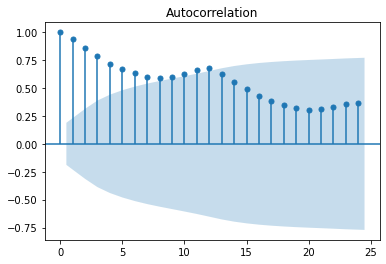

In [10]:
trn_acf = plot_acf(trn, lags=36)

### Linear Model

- Fit a linear regression model to serve as a baseline. 
- The dependent (or endogenous) variable is the number of passengers. 
- The independent (or exogenous) variable is a linear time trend, including a constant (or intercept).

In [11]:
lr = sm.OLS(endog=trn['#Passengers'], exog=sm.add_constant(np.arange(1, 1 + trn.shape[0]))).fit() 
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:            #Passengers   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     526.7
Date:                Sun, 01 Aug 2021   Prob (F-statistic):           6.40e-43
Time:                        10:42:09   Log-Likelihood:                -536.80
No. Observations:                 108   AIC:                             1078.
Df Residuals:                     106   BIC:                             1083.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         95.0422      6.820     13.936      0.0

- Extract the fitted values.

In [12]:
y_hat = lr.fittedvalues

- Extract the 95% prediction interval.

In [13]:
y_ci = lr.get_prediction().conf_int(alpha=0.05)

- Graph time series with linear regression line and corresponding 95% prediction interval.

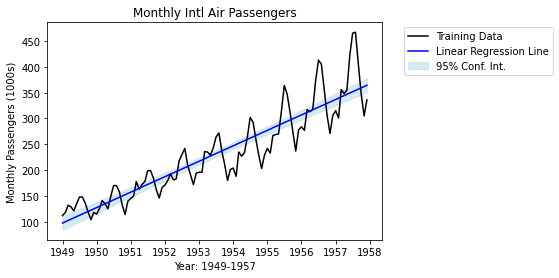

In [14]:
fig, ax = plt.subplots()
plt.xlabel('Year: 1949-1957')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly Intl Air Passengers')
plt.plot(trn, color='black', label='Training Data')
plt.plot(y_hat, color='blue', label='Linear Regression Line')
plt.fill_between(y_hat.index, y_ci[:, 0], y_ci[:, 1], color='lightblue', alpha=0.5, label='95% Conf. Int.')
plt.legend(bbox_to_anchor=(1.05, 1))
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

# Baseline model does not capture any of the seasonality associated with the data set

## ARIMA: Train Model

Find the best ARIMA order using the `auto_arima` function in the `pmdarima` package. Note that the `auto_arima` function assumes that the time series is non-seasonal by default (i.e. the seasonal period "m" is set equal to 1 by default). In what follows we set "m" equal to 12 to ensure that the selected optimal model takes into account the annual seasonality observed in the time series (one cycle every 12 months).    

Note: We are actually conducting a variation on ARIMA called "SARIMAX," or "Seasonal Auto-Regressive Integrated Moving Average with Exogenous Factors."

In [15]:
auto_arima_model = auto_arima(trn, m=12, with_intercept=False, suppress_warnings=True)
print(auto_arima_model.summary())

# Notice that the title of the table below is "SARIMAX" as opposed to "ARIMA"

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  108
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -350.001
Date:                            Sun, 01 Aug 2021   AIC                            704.001
Time:                                    10:42:13   BIC                            709.109
Sample:                                         0   HQIC                           706.065
                                            - 108                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2411      0.091     -2.648      0.008      -0.420      -0.063
sigma2        92.7499     13.439   

- The `auto_arima` function suggests `ARIMA(1,1,0)(0,1,0,12)`.    

First set of numbers is for the basic, non-seasonal model    
&nbsp;  1 &nbsp;&nbsp;&nbsp;    # p: Auto-regressive (AR) order   
&nbsp;  1 &nbsp;&nbsp;&nbsp;    # d: Integrate (I), or degree of differencing   
&nbsp;  0 &nbsp;&nbsp;&nbsp;    # q: Moving average (MA) order   

In [16]:
auto_arima_model.order

(1, 1, 0)

Second set of numbers is for seasonality    
&nbsp;  0 &nbsp;&nbsp;&nbsp;    # P: Auto-regressive (AR) order    
&nbsp;  1 &nbsp;&nbsp;&nbsp;    # D: Integrate (I), or degree of differencing    
&nbsp;  0 &nbsp;&nbsp;&nbsp;    # Q: Moving average (MA) order   
&nbsp;  12 &nbsp;  # M: Model period or seasonality   

In [17]:
auto_arima_model.seasonal_order

(0, 1, 0, 12)

**Extract the residuals i.e. differences between predicted values and actual values**

Residuals are useful in checking whether a model has adequately captured the information in the data. 

A good forecasting method will yield residuals with the following properties:

1. The residuals are uncorrelated. If there are correlations between residuals, then there is information left in the residuals which should be used in computing forecasts.

2. The residuals have zero mean. If the residuals have a mean other than zero, then the forecasts are biased.

In [18]:
resid = auto_arima_model.resid()

- Plot the standardized residuals.

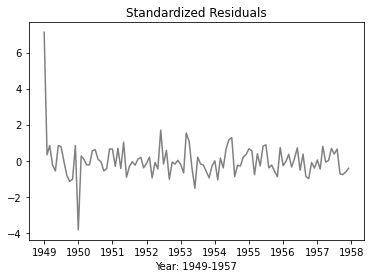

In [19]:
fig, ax = plt.subplots()
plt.plot(trn.index, stats.zscore(resid), color='gray')
plt.title('Standardized Residuals')
plt.xlabel('Year: 1949-1957')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

# Residuals settle in around 0 over time which means over model is predicting well

**Plot the AutoCorrelation Function (ACF) of the residuals.**

 - We can calculate the correlation for time series observations with observations with previous time steps, called lags. 
 - Because the correlation of the time series observations is calculated with values of the same series at previous times, this is called a serial correlation, or an autocorrelation.
 - A plot of the autocorrelation of a time series by lag is called the AutoCorrelation Function

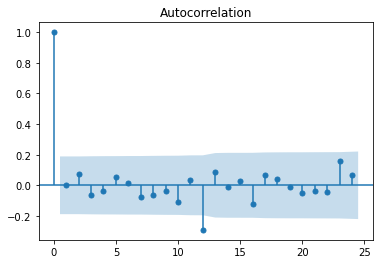

In [20]:
res_acf = plot_acf(resid, lags=24)

# Nearly all the lags have weak correlations

**Plot the p-values of the Ljung-Box test for autocorrelation.**

- The test checks if residual errors occur at random and are statistically insignificant
- Essentially, it is a test of "lack of fit"
 - if the autocorrelations of the residuals are very small, we say that the model doesn’t show ‘significant lack of fit’.

In [21]:
res_lb = acorr_ljungbox(resid, lags=24, return_df=False)[1]

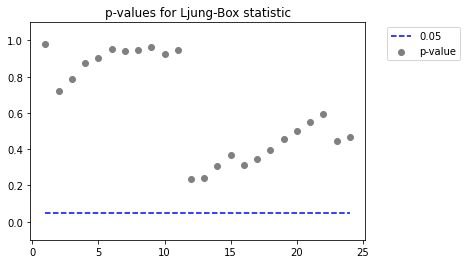

In [22]:
fig, ax = plt.subplots()
plt.title('p-values for Ljung-Box statistic')
plt.scatter(np.arange(1, 1 + len(res_lb)), res_lb, color='gray', label='p-value')
plt.plot(np.arange(1, 1 + len(res_lb)), [0.05] * len(res_lb), '--', color='blue', label='0.05')
plt.ylim(-0.1, 1.1)
plt.legend(bbox_to_anchor=(1.3, 1))

# All the autocorrelations of residuals are statistically insignificant i.e. p>0.05 

## Test Model

- Fit the best model to the training data.

In [23]:
auto_arima_model.fit(trn)

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

- Use the model to predict intervals for last three years.
- That is, apply the model to the testing dataset.

In [24]:
arima_predictions = auto_arima_model.predict(n_periods=36, alpha=0.05, return_conf_int=True)

- Extract the time series of model predictions.

In [25]:
y_pred = pd.Series(arima_predictions[0], index=tst.index)

- Extract the 95% prediction interval i.e. range within which actual value will fall into 95% of the time

In [26]:
y_pred_lb, y_pred_ub = arima_predictions[1][:, 0], arima_predictions[1][:, 1]

- Graph the training data (1949-1957).
- Add the predictions for the testing data (1958-1960).
- Add observed values from testing data.

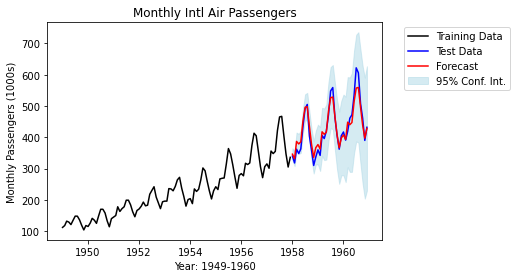

In [27]:
fig, ax = plt.subplots()
plt.xlabel('Year: 1949-1960')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly Intl Air Passengers')
plt.fill_between(tst.index, y_pred_lb, y_pred_ub, color='lightblue', alpha=0.5, label='95% Conf. Int.')
plt.plot(trn, color='black', label='Training Data')
plt.plot(tst, color='blue', label='Test Data')
plt.plot(y_pred, color='red', label='Forecast')
plt.legend(bbox_to_anchor=(1.05, 1))
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

# Training data stops at start of 1958
# We are trying to predict the values from 1958 onwards
# Forecasted values are trending very closely to actual values in test data

- Create a dataframe with the observed values for the testing dataset.
- Add the predictions from the ARIMA model.
- Add the low and high boundaries for the 95% confidence intervals.

In [28]:
tst_pred = pd.DataFrame({
    'Actual': tst.iloc[:, 0].values, 
    'Point Forecast': y_pred.values, 
    'Lo 95': y_pred_lb,
    'Hi 95': y_pred_ub
    }, index=tst.index)

In [29]:
tst_pred.head()
# Forecasted values are trending very closely to actual values in test data

,Actual,Point Forecast,Lo 95,Hi 95
Month,,,,
1958-01-01,340,345.964471,327.088699,364.840243
1958-02-01,318,331.731920,308.036230,355.427610
1958-03-01,362,386.787992,358.515741,415.060243
1958-04-01,348,378.774472,346.695455,410.853490
1958-05-01,363,385.777732,350.270765,421.284699
